# Data Cleaning and Preprocessing

In [1]:
import pandas as pd

# Load your dataset and parse the 'Datetime' column
data = pd.read_csv('final_resampled_data_1min_1hr.csv', parse_dates=['Datetime'])

# Convert 'Datetime' to timezone-aware if it's not already
data['Datetime'] = pd.to_datetime(data['Datetime'], utc=True)

# Get the current date and time in UTC for comparison
last_six_months = pd.Timestamp.now(tz='UTC') - pd.DateOffset(months=1)

# Filter for the last six months
filtered_data = data[data['Datetime'] >= last_six_months]

# Display the filtered data
print(filtered_data)

# Save the filtered dataset if needed
filtered_data.to_csv('hybrid.csv', index=False)

                        Datetime    Adj Close        Close         High  \
154895 2024-11-08 14:30:00+00:00  5989.580078  5989.580078  5992.439941   
154896 2024-11-08 14:31:00+00:00  5989.694743  5989.694743  5992.525439   
154897 2024-11-08 14:32:00+00:00  5989.809408  5989.809408  5992.610937   
154898 2024-11-08 14:33:00+00:00  5989.924072  5989.924072  5992.696436   
154899 2024-11-08 14:34:00+00:00  5990.038737  5990.038737  5992.781934   
...                          ...          ...          ...          ...   
160787 2024-12-03 20:26:00+00:00  6049.678581  6049.678581  6051.519303   
160788 2024-12-03 20:27:00+00:00  6049.676416  6049.676416  6051.509473   
160789 2024-12-03 20:28:00+00:00  6049.674251  6049.674251  6051.499642   
160790 2024-12-03 20:29:00+00:00  6049.672087  6049.672087  6051.489811   
160791 2024-12-03 20:30:00+00:00  6049.669922  6049.669922  6051.479980   

                Low         Open        Volume  
154895  5976.759766  5976.759766  0.000000e+00  
1

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import pandas as pd
lstm_data = pd.read_csv("filtered_last_two_months.csv")
transformer_data = pd.read_csv("final_resampled_data_1min_1hr.csv")
hybrid_data = pd.read_csv("hybrid.csv")

# Feature Engineering

In [3]:
def derive_features(df):
    # Ensure 'Datetime' is in the correct format and set as the index if necessary
    df['Datetime'] = pd.to_datetime(df['Datetime'], utc=True)

    # Time-based features
    df['Hour'] = df['Datetime'].dt.hour
    df['DayOfWeek'] = df['Datetime'].dt.dayofweek
    df['Quarter'] = df['Datetime'].dt.quarter
    df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

    # PriceChangePct (percentage change in 'Close' price)
    df['PriceChangePct'] = df['Close'].pct_change()

    # Rolling window features (15-period rolling)
    window = 5
    df['RollingMean_5'] = df['Close'].rolling(window=window).mean()
    df['RollingStd_5'] = df['Close'].rolling(window=window).std()
    df['RollingSkew_5'] = df['Close'].rolling(window=window).apply(lambda x: stats.skew(x), raw=True)

    # Exponential moving average (15-period EMA)
    df['EMA_5'] = df['Close'].ewm(span=window, adjust=False).mean()

    # Volatility (5-minute rolling standard deviation of PriceChangePct)
    df['Volatility_5min'] = df['PriceChangePct'].rolling(window=5).std()

    # Volume change
    df['VolumeChange'] = df['Volume'].diff()

    # Select the relevant columns for output
    columns_to_extract = [
        'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
        'Hour', 'DayOfWeek', 'Quarter', 'IsWeekend',
        'PriceChangePct', 'RollingMean_5', 'RollingStd_5',
        'RollingSkew_5', 'EMA_5', 'Volatility_5min', 'VolumeChange'
    ]

    # Return the DataFrame with the selected columns
    return df[columns_to_extract]

lstm_derived_data = derive_features(lstm_data)
transformer_derived_data = derive_features(transformer_data)
hybrid_derived_data = derive_features(hybrid_data)

/var/folders/m6/jy00w6796tqgk13k3clbk3d40000gn/T/ipykernel_54725/3770388927.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  df['RollingSkew_5'] = df['Close'].rolling(window=window).apply(lambda x: stats.skew(x), raw=True)


In [5]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

def preprocess_and_normalize(df):

    df.loc[:, :] = df.ffill().bfill()

    columns_to_normalize = [
        'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
        'PriceChangePct', 'RollingMean_5', 'RollingStd_5',
        'RollingSkew_5', 'EMA_5', 'Volatility_5min', 'VolumeChange'
    ]

    # Initialize the scaler
    scaler = MinMaxScaler()

    # Normalize the selected columns
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

    return df

# Preprocess and normalize the data
lstm_normalized = preprocess_and_normalize(lstm_derived_data)
transformer_normalized = preprocess_and_normalize(transformer_derived_data)
hybrid_normalized = preprocess_and_normalize(hybrid_derived_data)

/var/folders/m6/jy00w6796tqgk13k3clbk3d40000gn/T/ipykernel_54725/3668874416.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
/var/folders/m6/jy00w6796tqgk13k3clbk3d40000gn/T/ipykernel_54725/3668874416.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
/var/folders/m6/jy00w6796tqgk13k3clbk3d40000gn/T/ipykernel_54725/3668874416.py:19: SettingWithCopyWarning:

In [ ]:
graphdata = lstm_normalized[(lstm_normalized['Datetime'].dt.year == 2024) & (lstm_normalized['Datetime'].dt.month == 11)]

plt.figure(figsize=(12, 6))
plt.plot(graphdata['Datetime'], graphdata['Adj Close'], label='Data in November', color='blue')

# Adding labels and title
plt.title('Data Visualization for November', fontsize=16)
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()

In [6]:
print(hybrid_normalized.columns)
print(lstm_normalized.columns)
print(transformer_normalized.columns)

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Hour',
       'DayOfWeek', 'Quarter', 'IsWeekend', 'PriceChangePct', 'RollingMean_5',
       'RollingStd_5', 'RollingSkew_5', 'EMA_5', 'Volatility_5min',
       'VolumeChange'],
      dtype='object')
Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Hour',
       'DayOfWeek', 'Quarter', 'IsWeekend', 'PriceChangePct', 'RollingMean_5',
       'RollingStd_5', 'RollingSkew_5', 'EMA_5', 'Volatility_5min',
       'VolumeChange'],
      dtype='object')
Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Hour',
       'DayOfWeek', 'Quarter', 'IsWeekend', 'PriceChangePct', 'RollingMean_5',
       'RollingStd_5', 'RollingSkew_5', 'EMA_5', 'Volatility_5min',
       'VolumeChange'],
      dtype='object')


# LSTM data sequence

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


def create_sequences(data, target_col, sequence_length=60):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i+sequence_length].drop(columns=[target_col]).values
        target = data.iloc[i+sequence_length][target_col]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

sequence_length = 60
target_col = 'Adj Close'

X, y = create_sequences(lstm_normalized, target_col, sequence_length)
test_size = 0.2
test_split_index = int(len(X) * (1 - test_size))

Lstm_X_train, Lstm_X_test = X[:test_split_index], X[test_split_index:]
Lstm_y_train, Lstm_y_test = y[:test_split_index], y[test_split_index:]

print(f"Training set shape: {Lstm_X_train.shape}, {Lstm_y_train.shape}")
print(f"Testing set shape: {Lstm_X_test.shape}, {Lstm_y_test.shape}")

Training set shape: (10415, 60, 16), (10415,)
Testing set shape: (2604, 60, 16), (2604,)


# LSTM Training

In [8]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2

Lstm_model = Sequential([
    # First LSTM layer with l2 regularization
    LSTM(256, return_sequences=True, input_shape=(Lstm_X_train.shape[1], Lstm_X_train.shape[2]), 
         kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001)),
    Dropout(0.2),
    
    # Second LSTM layer with l2 regularization
    LSTM(128, return_sequences=False, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001)),
    Dropout(0.2),
    
    # Dense layers with l2 regularization
    Dense(10, activation='relu'),
    Dense(1)
])

# Compile the model
Lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Model summary
Lstm_model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 256)        │       279,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 477,973 (1.82 MB)

 Trainable params: 477,973 (1.82 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
Lstm_model_history = Lstm_model.fit(Lstm_X_train, Lstm_y_train,validation_data=(Lstm_X_test, Lstm_y_test),epochs=50,batch_size=64,callbacks=[early_stopping],verbose=1)

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 147ms/step - loss: 0.8384 - mae: 0.2418 - val_loss: 0.5283 - val_mae: 0.0591
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 152ms/step - loss: 0.4823 - mae: 0.0527 - val_loss: 0.3658 - val_mae: 0.0407
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 160ms/step - loss: 0.3368 - mae: 0.0428 - val_loss: 0.2582 - val_mae: 0.0284
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 178ms/step - loss: 0.2385 - mae: 0.0348 - val_loss: 0.1834 - val_mae: 0.0265
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 180ms/step - loss: 0.1691 - mae: 0.0303 - val_loss: 0.1294 - val_mae: 0.0229
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 173ms/step - loss: 0.1193 - mae: 0.0272 - val_loss: 0.0927 - val_mae: 0.0454
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 176ms/step - loss: 0.0838 - mae: 0.0255 - val_loss: 0.0642 - val_mae: 0.0303
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 176ms/step - loss: 0.0591 - mae: 0.0295 - val_loss: 0.0443 - val_mae: 0.0217
Epoch 9/50
163/163 ━━━━━━━━━━━━━

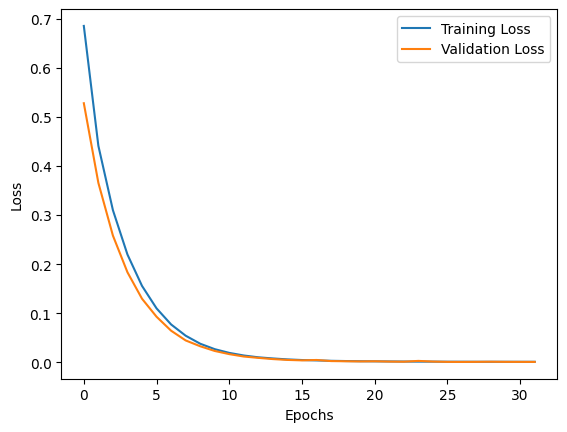

In [10]:
import matplotlib.pyplot as plt

plt.plot(Lstm_model_history.history['loss'], label='Training Loss')
plt.plot(Lstm_model_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<h2>Testing Lstm</h2>

In [11]:
y_pred = Lstm_model.predict(Lstm_X_test)
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(Lstm_y_test, y_pred))
print(f"RMSE: {rmse}")

# Calculate R-squared
r2 = r2_score(Lstm_y_test, y_pred)
print(f"R² Score:{r2}")

82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step
RMSE: 0.011896758862164201
R² Score:0.9854013876702878


# Transformer Data Sequence


In [12]:
# Data Preparation (assuming df_normalized has your data)
def create_sequences(data, target_col, sequence_length=60):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i + sequence_length].drop(columns=[target_col]).values
        target = data.iloc[i + sequence_length][target_col]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

sequence_length = 60
target_col = 'Adj Close'

# Assume df_normalized is your DataFrame
X, y = create_sequences(transformer_normalized, target_col, sequence_length)

# Train-Test Split
test_size = 0.2
test_split_index = int(len(X) * (1 - test_size))

X_train, X_test = X[:test_split_index], X[test_split_index:]
y_train, y_test = y[:test_split_index], y[test_split_index:]

# Transformer Training

In [13]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def build_transformer_model(
    input_shape, d_model=64, num_heads=4, ff_dim=128, dropout_rate=0.1
):
    inputs = Input(shape=input_shape)
    # Project inputs to d_model dimensions
    projected_inputs = Dense(d_model)(inputs)
    attention_output = MultiHeadAttention(
        num_heads=num_heads, key_dim=d_model
    )(projected_inputs, projected_inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = Add()([projected_inputs, attention_output])
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)
    ffn = Dense(ff_dim, activation='relu')(attention_output)
    ffn = Dense(d_model)(ffn)
    ffn = Dropout(dropout_rate)(ffn)
    ffn_output = Add()([attention_output, ffn])
    ffn_output = LayerNormalization(epsilon=1e-6)(ffn_output)
    outputs = Dense(1)(ffn_output[:, -1, :])
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

input_shape = X_train.shape[1:]
model = build_transformer_model(input_shape)
model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 60, 16)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 60, 64)    │      1,088 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 60, 64)    │     66,368 │ dense_2[0][0],    │
│ (MultiHeadAttentio… │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 60, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 60, 64)    │          0 │ dense_2[0][0],    │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 60, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 60, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 60, 64)    │      8,256 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 60, 64)    │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 60, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ get_item[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,353 (329.50 KB)

 Trainable params: 84,353 (329.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
4019/4019 ━━━━━━━━━━━━━━━━━━━━ 90s 22ms/step - loss: 0.0484 - mae: 0.1258 - val_loss: 0.0033 - val_mae: 0.0458
Epoch 2/50
4019/4019 ━━━━━━━━━━━━━━━━━━━━ 89s 22ms/step - loss: 0.0010 - mae: 0.0246 - val_loss: 0.0016 - val_mae: 0.0314
Epoch 3/50
4019/4019 ━━━━━━━━━━━━━━━━━━━━ 87s 22ms/step - loss: 4.3599e-04 - mae: 0.0161 - val_loss: 0.0011 - val_mae: 0.0287
Epoch 4/50
4019/4019 ━━━━━━━━━━━━━━━━━━━━ 87s 22ms/step - loss: 2.9545e-04 - mae: 0.0133 - val_loss: 4.6647e-04 - val_mae: 0.0170
Epoch 5/50
4019/4019 ━━━━━━━━━━━━━━━━━━━━ 86s 21ms/step - loss: 2.1099e-04 - mae: 0.0113 - val_loss: 4.6496e-04 - val_mae: 0.0158
Epoch 6/50
4019/4019 ━━━━━━━━━━━━━━━━━━━━ 88s 22ms/step - loss: 1.6807e-04 - mae: 0.0101 - val_loss: 3.5667e-04 - val_mae: 0.0154
Epoch 7/50
4019/4019 ━━━━━━━━━━━━━━━━━━━━ 87s 22ms/step - loss: 1.4088e-04 - mae: 0.0092 - val_loss: 5.0694e-04 - val_mae: 0.0170
Epoch 8/50
4019/4019 ━━━━━━━━━━━━━━━━━━━━ 90s 22ms/step - loss: 1.1475e-04 - mae: 0.0083 - val_loss: 3.2951e-0

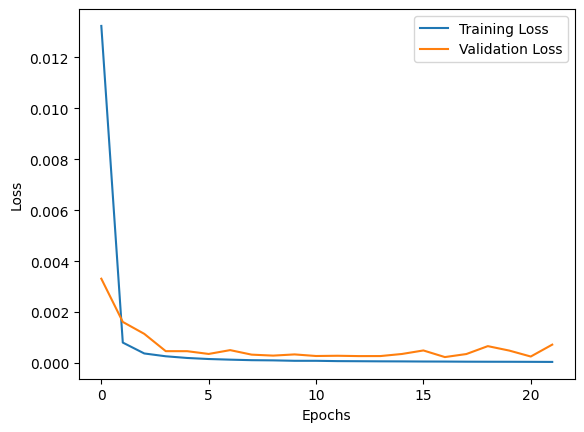

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
y_pred = model.predict(X_test)
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f"R² Score:{r2}")

1005/1005 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step
RMSE: 0.015263444681488322
R² Score:0.9695656959997048


# Simple Averaging

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


def create_sequences(data, target_col, sequence_length=60):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i+sequence_length].drop(columns=[target_col]).values
        target = data.iloc[i+sequence_length][target_col]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

sequence_length = 60
target_col = 'Adj Close'

X, y = create_sequences(hybrid_normalized, target_col, sequence_length)
test_size = 0.2
test_split_index = int(len(X) * (1 - test_size))

Hybrid_X_train, Hybrid_X_test = X[:test_split_index], X[test_split_index:]
Hybrid_y_train, Hybrid_y_test = y[:test_split_index], y[test_split_index:]

print(f"Training set shape: {Hybrid_X_train.shape}, {Hybrid_y_train.shape}")
print(f"Testing set shape: {Hybrid_X_test.shape}, {Hybrid_y_test.shape}")

Training set shape: (4669, 60, 16), (4669,)
Testing set shape: (1168, 60, 16), (1168,)


In [17]:
lstm_training_predictions = Lstm_model.predict(Hybrid_X_train)
transformer_training_predictions = model.predict(Hybrid_X_train)

# Average the predictions
final_predictions = (lstm_training_predictions + transformer_training_predictions)/2
rmse = np.sqrt(mean_squared_error(final_predictions, Hybrid_y_train))
print(f"RMSE: {rmse}")

# Calculate R-squared
r2 = r2_score(final_predictions, Hybrid_y_train)
print(f"R² Score:{r2}")

146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
RMSE: 0.020453786622507256
R² Score:0.9927728683247217


# Weighted Averaging

In [19]:
weight_lstm = 0.1
weight_transformer = 0.9
final_predictions = weight_lstm * lstm_training_predictions + weight_transformer * transformer_training_predictions

rmse = np.sqrt(mean_squared_error(final_predictions, Hybrid_y_train))
print(f"RMSE: {rmse}")

# Calculate R-squared
r2 = r2_score(final_predictions, Hybrid_y_train)
print(f"R² Score:{r2}")

RMSE: 0.023271682220420125
R² Score:0.9903136336974384


# Stacking

In [23]:
from sklearn.linear_model import LinearRegression

# Create a new dataset with predictions from both models
lstm_predictions = Lstm_model.predict(Hybrid_X_test)
transformer_predictions = model.predict(Hybrid_X_test)
combined_predictions = np.column_stack((lstm_training_predictions, transformer_training_predictions))
combined_results = np.column_stack((lstm_predictions, transformer_predictions))

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Initialize the Linear Regression model
linear_regressor = LinearRegression()

# Fit the model on the combined predictions
linear_regressor.fit(combined_predictions, Hybrid_y_train)

# Predict the final output
final_predictions_lr = linear_regressor.predict(combined_results)

# Evaluate the Linear Regression model
mse = mean_squared_error(Hybrid_y_test, final_predictions_lr)
mae = mean_absolute_error(Hybrid_y_test, final_predictions_lr)
r2 = r2_score(Hybrid_y_test, final_predictions_lr)

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Mean Squared Error (MSE): 0.00
Mean Absolute Error (MAE): 0.02
R-squared (R2): 0.95


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Define the neural network architecture
def build_neural_network(input_dim):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=input_dim))  # Input layer
    model.add(Dropout(0.2))  # Dropout to reduce overfitting
    model.add(Dense(64, activation='relu'))  # Hidden layer
    model.add(Dropout(0.2))  # Dropout to reduce overfitting
    model.add(Dense(1))  # Output layer (regression)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
    return model

# Get the input dimensions (number of features)
input_dim = combined_predictions.shape[1]

# Build the model
nn_model = build_neural_network(input_dim)

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitors validation loss
    patience=5,          # Stops training after 5 epochs without improvement
    restore_best_weights=True  # Restores best weights
)

# Train the neural network
history = nn_model.fit(
    combined_predictions, 
    y, 
    validation_split=0.2,  # Use 20% of the data for validation
    epochs=50, 
    batch_size=32, 
    verbose=1
)

# Predict the final output
final_predictions_nn = nn_model.predict(combined_results)

# Evaluate the Neural Network model
mse = mean_squared_error(Hybrid_y_test, final_predictions_nn)
mae = mean_absolute_error(Hybrid_y_test, final_predictions_nn)
r2 = r2_score(Hybrid_y_test, final_predictions_nn)

rmse = mean_squared_error(Hybrid_y_test, final_predictions_nn)
print(f"RMSE: {rmse}")

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 970us/step - loss: 0.0894 - mae: 0.1941 - val_loss: 0.0014 - val_mae: 0.0324
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 0.0062 - mae: 0.0574 - val_loss: 3.7335e-04 - val_mae: 0.0130
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 0.0048 - mae: 0.0502 - val_loss: 5.5365e-04 - val_mae: 0.0191
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 0.0044 - mae: 0.0478 - val_loss: 8.9533e-04 - val_mae: 0.0256
Epoch 5/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 0.0039 - mae: 0.0459 - val_loss: 3.2769e-04 - val_mae: 0.0127
Epoch 6/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 0.0035 - mae: 0.0436 - val_loss: 3.6509e-04 - val_mae: 0.0144
Epoch 7/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 0.0034 - mae: 0.0427 - val_loss: 8.7693e-04 - val_mae: 0.0251
Epoch 8/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 0.0031 - mae: 0.0407 - val_loss: 5.1939e-04 - val_mae: 0.0181
Epoch 9/50
1

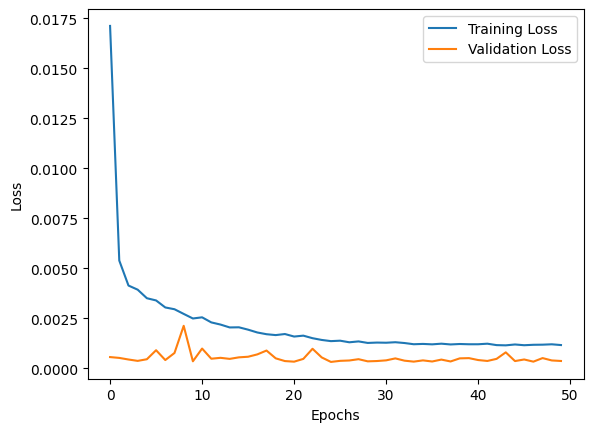

In [36]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Compairing Results

In [34]:
Lstm_model.save('lstm_model.keras')

In [35]:
model.save('model.keras')

# Conclusion